<a href="https://colab.research.google.com/github/mrzResearchArena/ACP/blob/master/ACP-740.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [1]. Google Drive Initialization:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [3]:
cd 'drive/My Drive/Colab-Notebooks'

/content/drive/My Drive/Colab-Notebooks


In [4]:
ls -1

0_FINAL_anti_peptide_model_AC240-tensorboard.ipynb
0_FINAL_anti_peptide_model_ACP740-tensorboard.ipynb
500-164.h5
544_encoded_sequences_740.npy
ACP164.npy
ACP240_labels.npy
acp240.txt
ACP500.npy
ACP740_labels.npy
ACP-740-tensorboard.ipynb
acp740.txt
blosum62-acp240.npy
blosum62-acp740.npy
BPF_coded_ACP164_sequences.npy
BPF_coded_ACP240_sequences.npy
BPF_coded_ACP500_sequences.npy
BPF_coded_ACP740_sequences.npy
kmer_k_3_ACP240.npy
kmer_k_3_ACP740.npy
logs/
mACP-240.ipynb
mACP-740.ipynb
model-240.png
model-500-164.png
model-740.png
model.png
multichannel.png
physico_coded_ACP164_sequences.npy
physico_coded_ACP240_sequences.npy
physico_coded_ACP500_sequences.npy
physico_coded_ACP740_sequences.npy


## [2]. Load Deep Learning API (Keras):

In [5]:
# Deep Neural Networks:
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                          Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, concatenate,
                          SimpleRNN, LSTM, GRU, Bidirectional, Embedding)
from keras.regularizers import (l1, l2, l1_l2)
from keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import (Sequential, Model)
import keras; print('We\'re using Keras version: {}.'.format(keras.__version__))

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, mean_squared_error, 
                             matthews_corrcoef, precision_score)

#Utilities
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import to_categorical as labelEncoding # Usages: Ytrain = labelEncoding(Ytrain, dtype=int)
from keras.utils import plot_model                      # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)
#end-import

Using TensorFlow backend.


We're using Keras version: 2.2.5.


## [3]. Load Datasets:

In [6]:
D = 26 # terminus_length

X1 = np.load('BPF_coded_ACP740_sequences.npy')
X2 = np.load('physico_coded_ACP740_sequences.npy')
X3 = np.load('blosum62-acp740.npy')

X3 = X3.reshape(-1, 20, 11)

Y = np.load('ACP740_labels.npy')
Y = labelEncoding(Y, dtype=int)


print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)


X1 = X1[:,:,0:D]
X2 = X2[:,:,0:D]
X3 = X3[:,:,:]
print('### --- --- ###')


print(X1.shape)
print(X2.shape)
print(X3.shape)
print(Y.shape)

(740, 20, 207)
(740, 7, 97)
(740, 20, 11)
(740, 2)
### --- --- ###
(740, 20, 26)
(740, 7, 26)
(740, 20, 11)
(740, 2)


## [4]. Generate Model:

In [0]:
def Network():
    ### Head-1:
    input1 = Input(shape=(20, D)) # T=20

    x = Conv1D(filters=32, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    head1 = Flatten()(x)


    ### Head-2:
    input2 = Input(shape=(7, D)) # T=7

    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(input2)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=4, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    head2 = Flatten()(x)


    ### Head-3:
    input3 = Input(shape=(20, 11)) 
    
    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(input3)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=12, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first',activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)

    head3 = Flatten()(x)


    # merge
    merge = concatenate(inputs=[head1, head2, head3])

    output = Dense(units=16, activation='relu',)(merge)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.5)(output)

    output = Dense(units=8, activation='relu',)(output)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.5)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1, input2, input3], outputs=[output])
#end-def











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 26)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 7, 26)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 20, 11)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 32, 26)       1952        i

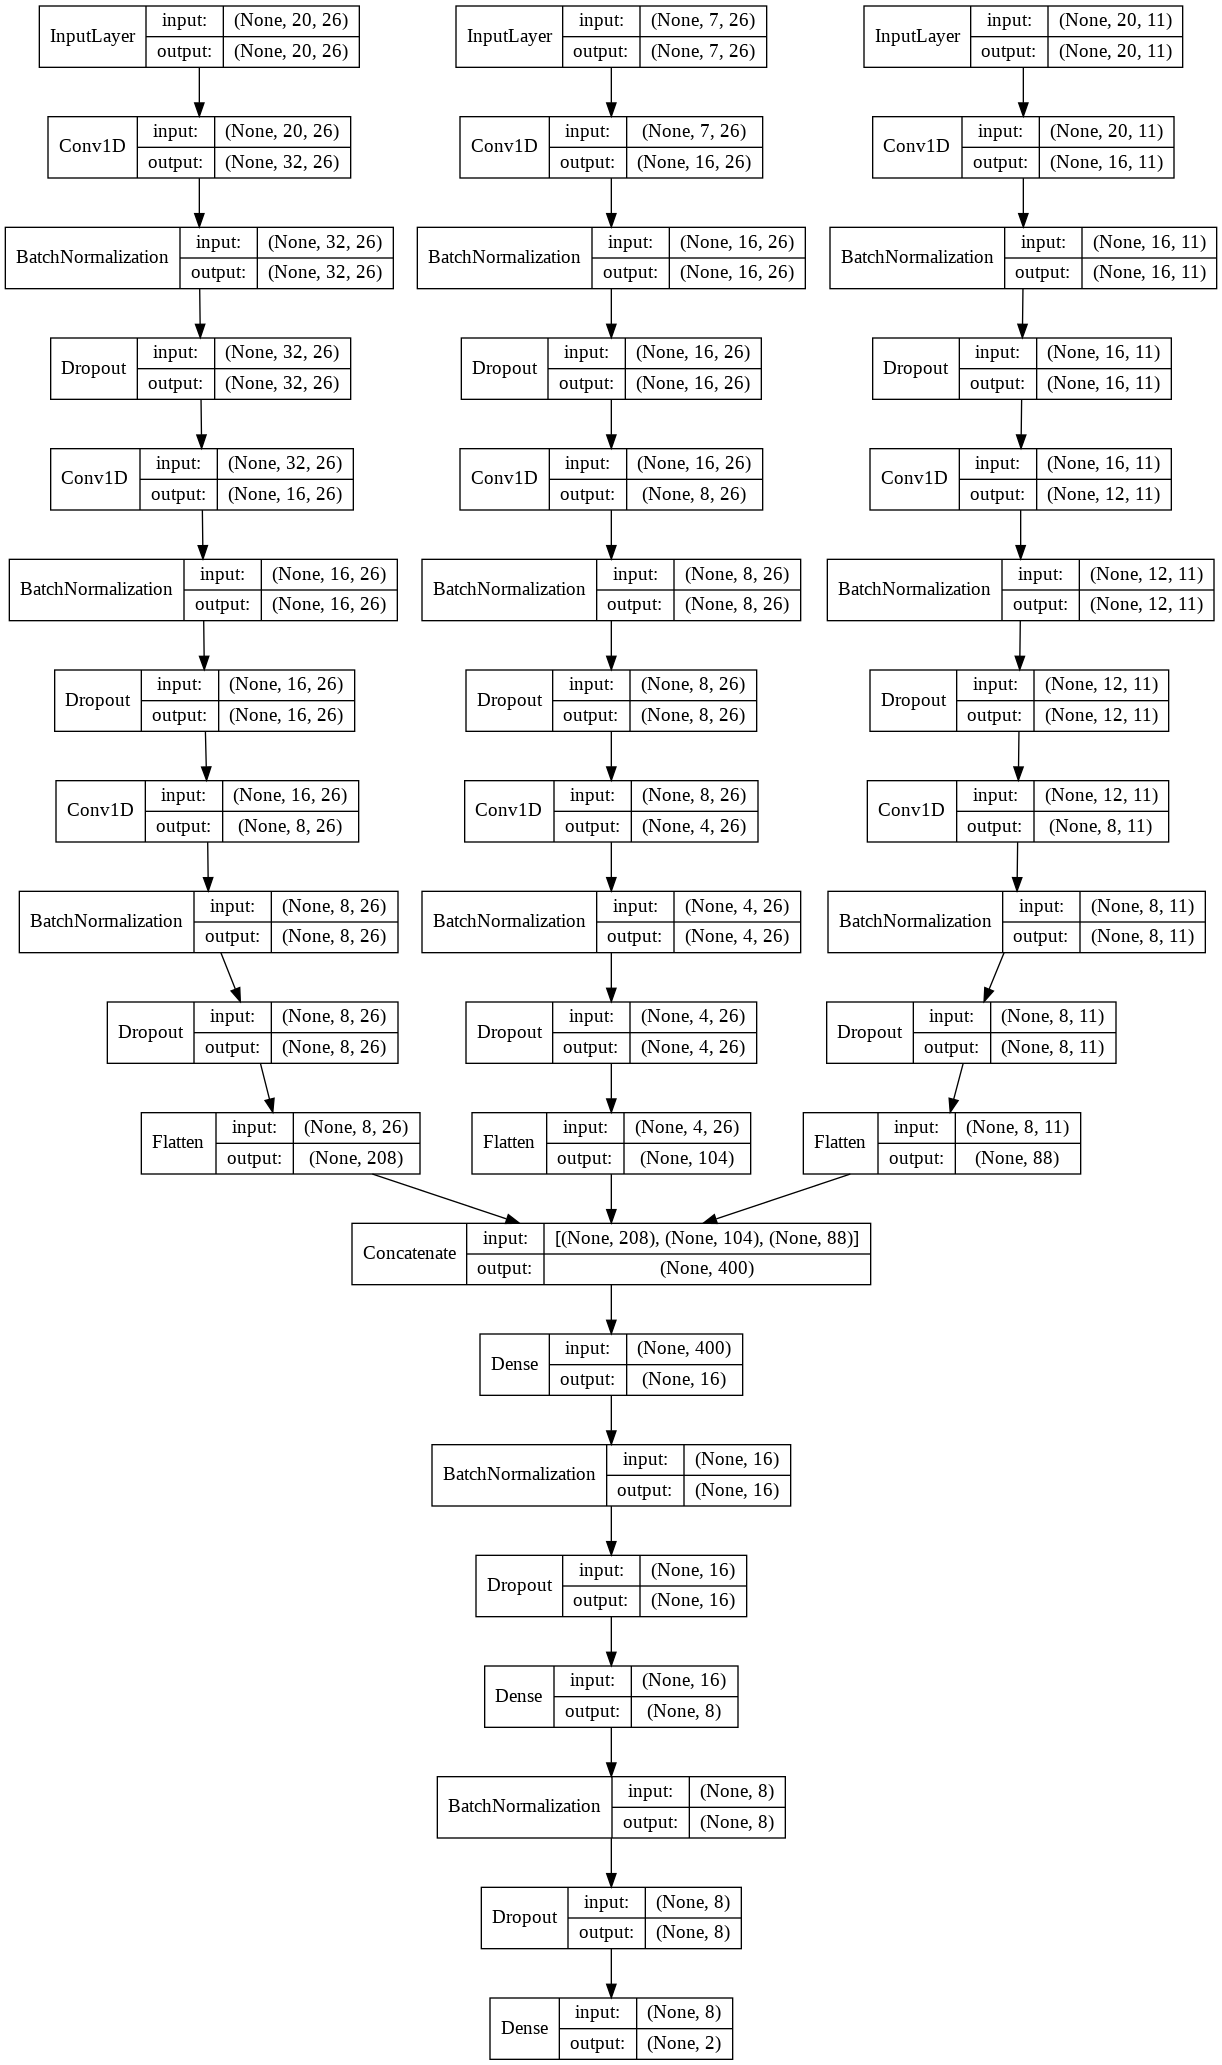

In [8]:
model = Network()
model.summary()
plot_model(model, to_file='model-740.png', show_shapes=True, show_layer_names=False, expand_nested=True)

In [0]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['acc'], label='Training Accuracy')
    plt.plot(results.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

## [5]. Run Model:



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 592 samples, validate on 148 samples
Epoch 1/500
592/592 [==============================] - 11s 18ms/step - loss: 1.2573 - acc: 0.4932 - val_loss: 0.7037 - val_acc: 0.5203
Epoch 2/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1992 - acc: 0.5084 - val_loss: 0.6999 - val_acc: 0.5338
Epoch 3/500
592/592 [==============================] - 1s 2ms/step - loss: 1.2200 - acc: 0.4983 - val_loss: 0.6991 - val_acc: 0.5608
Epoch 4/500
592/592 [==============================] - 1s 2ms/step - loss: 1.3351 - acc: 0.4662 - val_loss: 0.6993 - val_acc: 0.5338
Epoch 5/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1462 - acc: 0.4831 - val_loss: 0.6975 - val_acc: 0.5608
Epoch 6/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1403 - acc: 0.5000 - val_loss: 0.7003 - val_acc: 0.5338
Epoch 7/500
592/592 [==============================] - 1

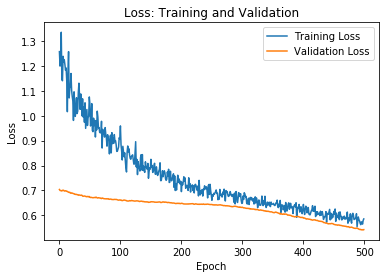

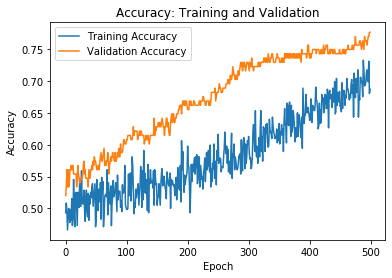

#################################################
Train on 592 samples, validate on 148 samples
Epoch 1/500
592/592 [==============================] - 5s 9ms/step - loss: 1.2233 - acc: 0.5118 - val_loss: 0.7564 - val_acc: 0.4797
Epoch 2/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1463 - acc: 0.5101 - val_loss: 0.7422 - val_acc: 0.4797
Epoch 3/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1437 - acc: 0.5034 - val_loss: 0.7416 - val_acc: 0.4730
Epoch 4/500
592/592 [==============================] - 1s 2ms/step - loss: 1.2178 - acc: 0.4916 - val_loss: 0.7406 - val_acc: 0.4797
Epoch 5/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1858 - acc: 0.4713 - val_loss: 0.7346 - val_acc: 0.4730
Epoch 6/500
592/592 [==============================] - 1s 2ms/step - loss: 1.0445 - acc: 0.5253 - val_loss: 0.7331 - val_acc: 0.4865
Epoch 7/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1579 - acc: 0.4899 - val_loss

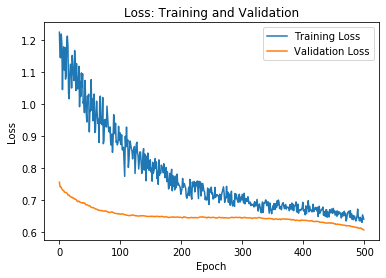

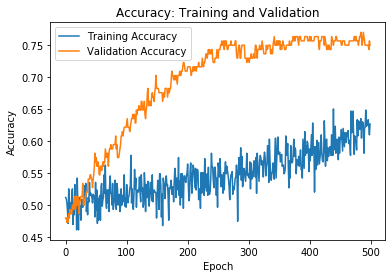

#################################################
Train on 592 samples, validate on 148 samples
Epoch 1/500
592/592 [==============================] - 6s 10ms/step - loss: 1.1407 - acc: 0.5034 - val_loss: 0.8735 - val_acc: 0.5000
Epoch 2/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1386 - acc: 0.5186 - val_loss: 0.8863 - val_acc: 0.5000
Epoch 3/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1914 - acc: 0.4831 - val_loss: 0.8767 - val_acc: 0.5000
Epoch 4/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1357 - acc: 0.4966 - val_loss: 0.8751 - val_acc: 0.5000
Epoch 5/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1710 - acc: 0.4662 - val_loss: 0.8777 - val_acc: 0.5000
Epoch 6/500
592/592 [==============================] - 1s 2ms/step - loss: 1.0914 - acc: 0.5355 - val_loss: 0.8699 - val_acc: 0.5000
Epoch 7/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1415 - acc: 0.5068 - val_los

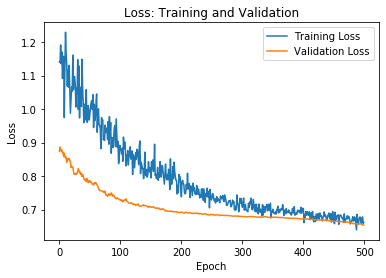

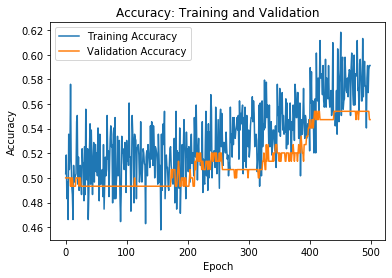

#################################################
Train on 592 samples, validate on 148 samples
Epoch 1/500
592/592 [==============================] - 7s 12ms/step - loss: 0.8891 - acc: 0.5000 - val_loss: 0.7396 - val_acc: 0.4662
Epoch 2/500
592/592 [==============================] - 1s 2ms/step - loss: 0.9265 - acc: 0.5000 - val_loss: 0.7369 - val_acc: 0.4662
Epoch 3/500
592/592 [==============================] - 1s 2ms/step - loss: 0.9515 - acc: 0.4983 - val_loss: 0.7376 - val_acc: 0.4730
Epoch 4/500
592/592 [==============================] - 1s 2ms/step - loss: 0.8890 - acc: 0.5203 - val_loss: 0.7359 - val_acc: 0.4730
Epoch 5/500
592/592 [==============================] - 1s 2ms/step - loss: 0.9660 - acc: 0.5135 - val_loss: 0.7349 - val_acc: 0.4797
Epoch 6/500
592/592 [==============================] - 1s 2ms/step - loss: 0.9011 - acc: 0.5321 - val_loss: 0.7334 - val_acc: 0.4730
Epoch 7/500
592/592 [==============================] - 1s 2ms/step - loss: 0.9182 - acc: 0.5372 - val_los

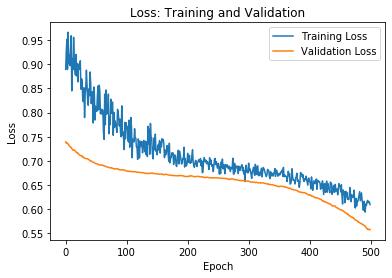

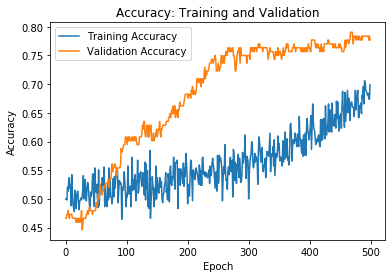

#################################################
Train on 592 samples, validate on 148 samples
Epoch 1/500
592/592 [==============================] - 8s 14ms/step - loss: 1.2248 - acc: 0.5034 - val_loss: 0.7389 - val_acc: 0.5473
Epoch 2/500
592/592 [==============================] - 1s 2ms/step - loss: 1.3025 - acc: 0.4899 - val_loss: 0.7254 - val_acc: 0.5608
Epoch 3/500
592/592 [==============================] - 1s 2ms/step - loss: 1.2647 - acc: 0.5051 - val_loss: 0.7204 - val_acc: 0.5541
Epoch 4/500
592/592 [==============================] - 1s 2ms/step - loss: 1.3482 - acc: 0.4662 - val_loss: 0.7166 - val_acc: 0.5338
Epoch 5/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1387 - acc: 0.5270 - val_loss: 0.7119 - val_acc: 0.5405
Epoch 6/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1664 - acc: 0.5169 - val_loss: 0.7101 - val_acc: 0.5405
Epoch 7/500
592/592 [==============================] - 1s 2ms/step - loss: 1.1566 - acc: 0.5473 - val_los

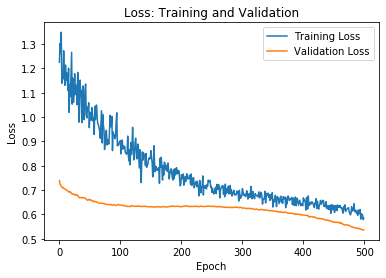

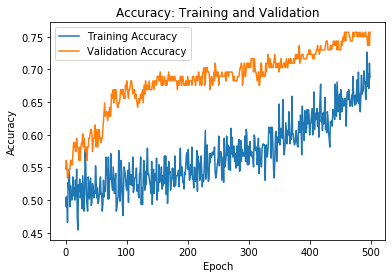

#################################################
[0.7770270286379634, 0.7499999983890636, 0.547297295686361, 0.7770270238051543, 0.756756753534884]
Accuracy: 0.72
Sensitivity: 0.5579
Specificity: 0.8807
MCC: 0.4676
Precision: 0.8296


In [10]:
setEpochNumber     = 500     # 2,500 performed well.
setBatchSizeNumber = 16
####################################################

cv = KFold(n_splits=5, shuffle=True)

Accuracy = []
Sensitivity = []
Specificity = []
Precision = []
MCC = []

# CM = np.array([
#      [0, 0],
#      [0, 0],
# ], dtype=int)

for train, test in cv.split(Y):

    # Compile Model:
    model = Network()
    model.compile(optimizer=Adam(lr=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Run Model:
    results = model.fit(x=[X1[train,:,:],X2[train,:,:],X3[train,:,:]], y=[Y[train,:]], validation_data=([X1[test,:,:], X2[test,:,:], X3[test,:,:]], [Y[test,:]]), epochs=setEpochNumber, batch_size=setBatchSizeNumber, verbose=1)

    # Evaluate the Model:
    accuracy = model.evaluate(x=[X1[test,:,:], X2[test,:,:], X3[test,:,:]], y=Y[test,:])
    Accuracy.append(accuracy[1])
    
    # Performance Metices:
    Yactual = Y[test,:].argmax(axis=1)
    Yp = model.predict([X1[test,:,:], X2[test,:,:], X3[test,:,:]])
    Yp = Yp.argmax(axis=1)

    CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
    TN, FP, FN, TP = CM.ravel()

    MCC.append(matthews_corrcoef(y_true=Yactual, y_pred=Yp))
    Sensitivity.append( TP / (TP + FN) )
    Specificity.append( TN / (TN + FP) )
    Precision.append(precision_score(y_true=Yactual, y_pred=Yp))
    
    
    # Performance Plot
    print('#################################################')
    print('Fold\'s Accuracy: {:.2f}'.format(accuracy[1]*100.0))
    lossPlot(results)
    accuracyPlot(results)
    print('#################################################')
#end-for

print(Accuracy)
print('Accuracy: {:.2f}'.format(np.sum(Accuracy)/5.0))
print('Sensitivity: {0:.4f}'.format(np.sum(Sensitivity)/5.00))
print('Specificity: {0:.4f}'.format(np.sum(Specificity)/5.00))
print('MCC: {0:.4f}'.format(np.sum(MCC)/5.00))
print('Precision: {0:.4f}'.format(np.sum(Precision)/5.00))